# NearestNeighbors classifier on MNist data set - multi machine execution using dask and persistant storage

## Task 1 - Load the Mnist data set

In [1]:
%%time
from keras.datasets import mnist
from numpy import save

# split data into training and testing 60000/10000
(x_train, y_train), (x_test, y_test) = mnist.load_data()


print(len(x_train))
print(len(x_test))
print(x_train.shape)
print(x_test.shape)
training_size = len(x_train)
testing_size = len(x_test)
print(f"train size : {training_size}, testing size : {testing_size}")

60000
10000
(60000, 28, 28)
(10000, 28, 28)
train size : 60000, testing size : 10000
CPU times: user 1.39 s, sys: 516 ms, total: 1.91 s
Wall time: 2.89 s


## Task 2 - Pre-proccessing of dataset

(10000, 28, 28)
(60000, 28, 28)


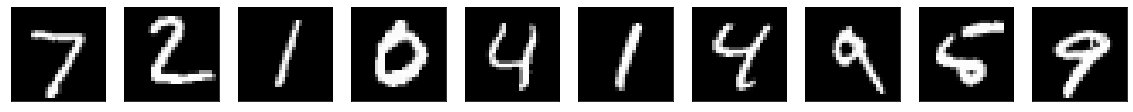

CPU times: user 515 ms, sys: 172 ms, total: 688 ms
Wall time: 646 ms


In [2]:
%%time
import sys
import time
sys.path.append('../')
from Utils.Utils import Utils
import numpy as np


# Recaculate values so result is normalized between 0-1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test  /= 255
print(x_test.shape)
print(x_train.shape)
x_train = x_train.reshape([60000,784])
x_test = x_test.reshape([10000,784])

# Store the data on shared data volume (shared virtuel drive)
with open('/home/ubuntuserver/task-pv-claim/x_test.npy', 'wb') as f:
    np.save(f, x_test)
    
with open('/home/ubuntuserver/task-pv-claim/y_test.npy', 'wb') as f:
    np.save(f, y_test)

# print examples
util_provider = Utils()
util_provider.show_imgs(x_test, 28)

## Task 3 - Training

In [3]:
%%time
import numpy as np
from sklearn import neighbors
from joblib import dump, load

model = neighbors.KNeighborsClassifier(n_neighbors=8, weights='uniform')

# Fit model
model.fit(x_train, y_train)

# Store the trained model on shared data volume (shared virtuel drive)
dump(model, '/home/ubuntuserver/task-pv-claim/model.joblib')

CPU times: user 328 ms, sys: 211 ms, total: 539 ms
Wall time: 1.08 s


['/home/ubuntuserver/task-pv-claim/model.joblib']

### Setup connection to kubernetes dask cluster 

In [4]:
from dask.distributed import Client
import sys
sys.path.append('../')
from Utils.Utils import Utils


scheduler_ip = Utils().get_scheduler_ip()
# 10.x.x.x is the virtuel ip of the dask scheduler within the kubernetes cluster
client = Client(f"{scheduler_ip}:8786", timeout=3)
client

<Client: 'tcp://10.42.0.28:8786' processes=4 threads=4, memory=18.63 GiB>

## Task 4 - Model evaluation

In [5]:
%%time
## 10 pods working together to solve the problem
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask
from dask.diagnostics import visualize
from dask.distributed import performance_report

def load_data_from_disk():
    fd_x_test = open('/home/ubuntuserver/rapids/R-D/pv-claim/x_test.npy', 'rb')
    fd_y_test = open('/home/ubuntuserver/rapids/R-D/pv-claim/y_test.npy', 'rb')
    
    x_test = np.load(fd_x_test) 
    y_test = np.load(fd_y_test)
    
    fd_x_test.close()
    fd_y_test.close()
    
    model = load('/home/ubuntuserver/rapids/R-D/pv-claim/model.joblib') 
    return (model, x_test, y_test)

@dask.delayed
def predict(start, end):
    from numpy import load
    from joblib import dump, load
    model, x_test, y_test = load_data_from_disk()
    
    return model.score(x_test[start:end], y_test[start:end])

@dask.delayed
def mean_score(scores, chunk_size):

    return sum(scores)/chunk_size


number_of_dask_workers = 4

tasks_delayed = []
start_index = 0
chunk_size = int(testing_size/number_of_dask_workers)
print(chunk_size)

for i in range(chunk_size,int(chunk_size+testing_size),chunk_size):
    tasks_delayed.append(predict(start_index,i))
    print(f"chunk start/end : {start_index}/{i}")
    start_index = i

mean_delayed = mean_score(tasks_delayed, number_of_dask_workers)
    
mean_delayed.visualize("reports/KNN persist and compute")

with performance_report("reports/KNN persist and compute.html"):
    aggregated_mean_score = mean_delayed.compute()
    print(f"score : {aggregated_mean_score}")

2500
chunk start/end : 0/2500
chunk start/end : 2500/5000
chunk start/end : 5000/7500
chunk start/end : 7500/10000
score : 0.9669999999999999
CPU times: user 456 ms, sys: 151 ms, total: 607 ms
Wall time: 22.9 s


In [6]:
#%%time
# 2 pod working alone to solve the problem with dask
#score = predict(0,10000)
#score.visualize('reports/single worker storage.png')
#future = client.compute(score)
#print(f"score : {future.result()}")

In [7]:
#%%time
# same as above - 2 cpu working alone to solve the problem without dask

def predict(start, end):
    from numpy import load
    from joblib import dump, load
    import numpy as np
    
    fd_x_test = open('/home/ubuntuserver/task-pv-claim/x_test.npy', 'rb')
    fd_y_test = open('/home/ubuntuserver/task-pv-claim/y_test.npy', 'rb')
    
    x_test = np.load(fd_x_test) 
    y_test = np.load(fd_y_test)
    
    fd_x_test.close()
    fd_y_test.close()
    
    model = load('/home/ubuntuserver/task-pv-claim/model.joblib') 
    return model.score(x_test[start:end], y_test[start:end])


#score = predict(0,10000)
#print(f"score : {score}")